# Assignment 1 MTA Cardtype Timeseries Analysis Part I
yg833

This assignment is a continuation from the week prior. In the prior week, I worked with a number of colleagues from class - QY (qg412), Jerome (jl9489), Andrea(ah4412), Fekade Brook (fb1182), and Sam (sjf374). Mainly, we worked alongside each other thinking out loud and comparing outputs.

For this week, I worked with QY(qg412), Rachel (rms818), Khloe(kyn227) and Tiffany (tp1600)

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


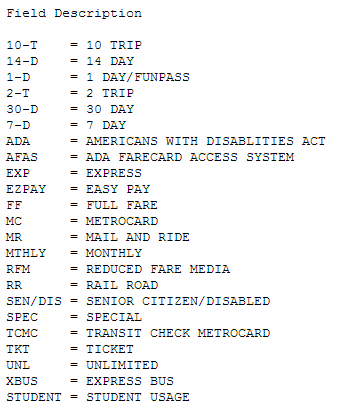

In [120]:
# set up libraries
from __future__ import print_function, division

import os
import sys
import urllib
import io

import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import mixture


%matplotlib inline
%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [121]:
# setting environmental variable
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print(os.environ["PUIDATA"])

/nfshome/yg833/PUIdata


In [122]:
# url for mta fare data
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy' 

# retrieve csv file from the url
urllib.request.urlretrieve(url, 'MTA_Fare.npy')

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7ff116d51e48>)

In [123]:
# move the file to PUIData folder
!mv MTA_Fare.npy $PUIDATA

In [124]:
mta = np.load(os.environ["PUIDATA"]+'/MTA_Fare.npy')

In [125]:
shape(mta)

(600, 23, 194)

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

### read in data as instructed above

In [126]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [127]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

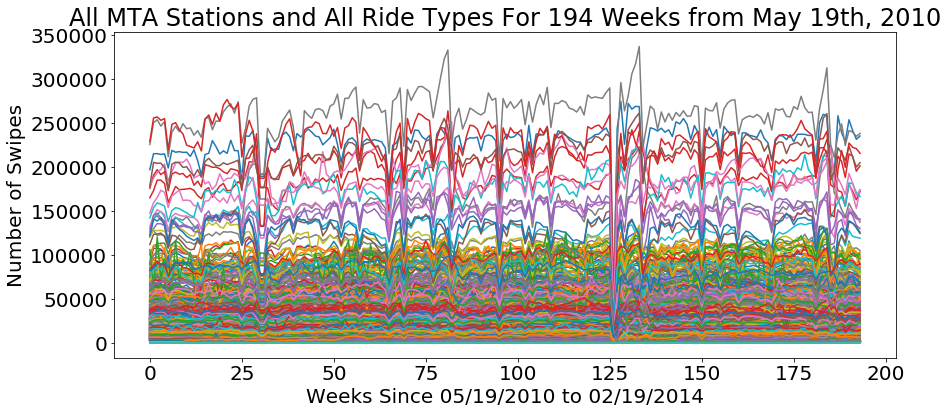

In [128]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(mta[i,j])

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

### Figure 1: Plot of mta swipes data with x axis as weeks between 05/19/2010 and 02/19/2014. The plot is very messy and kind of hard to read. There appears to be many dips at around (all approximate reads of the x-axis) week 27, week 70, week 90, week 127, week 150 and so on. The obvious valleys were around week 80 and week 130.  

In [129]:
# convert the mta cube with -1s  into float and convert to nans
mta = mta[:].astype(float)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

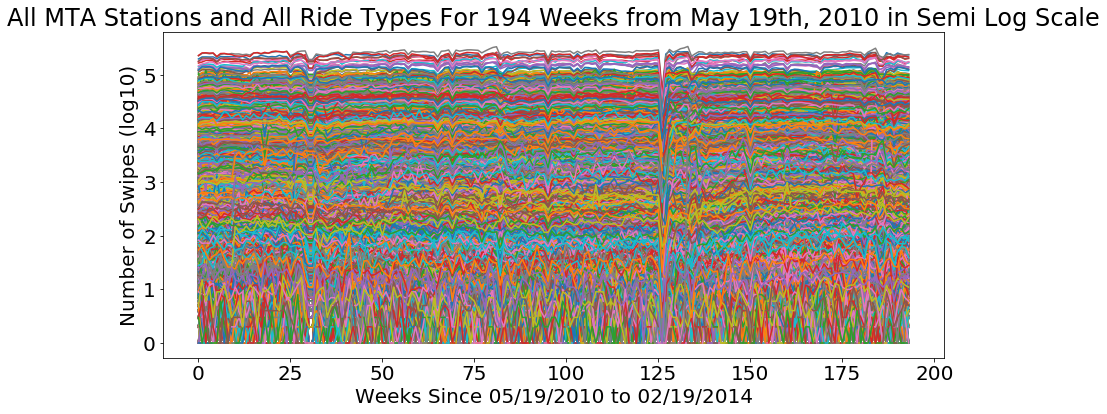

In [130]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 2: Time series for all rides types and all stations in semi-log space. The plot is still kind of messy still but easier to read than compared to the one in Figure 1. From this second plot, it seems like the dip was at around week 125. 

In [131]:
dates_studied = pd.date_range(start = '2010/05/19', periods=194, freq='W-WED') # creats a date range for this analysis

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

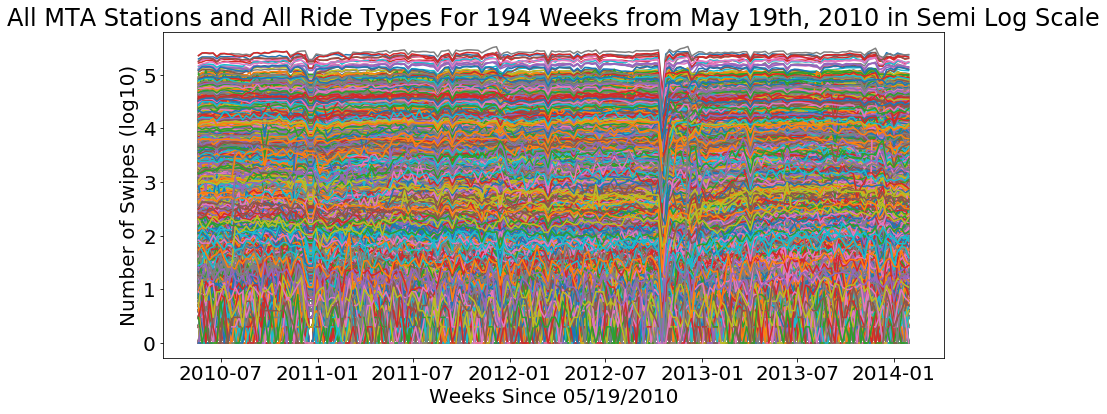

In [132]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(dates_studied,np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 3: Same as figure 2 but changing the x-axis to read the date of week instead of the week number.

# Task 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 

### MG's note: In class, Dr. Bianco showed several different samples for event detention. So in trying to complete Task 1, event detention, we looked at both the point of change and the FDNY notebooks. 

In [133]:
# define point of change function from Dr. Bianco's repo
# Dr. Bianco's code
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

In [134]:
# using the change finder function to find the point of change.
ppoc = changeFinder(mta[0][0])
dates_studied[ppoc['pointOfChange']]

Timestamp('2012-10-24 00:00:00', freq='W-WED')

### MG's note: From the point of change function, it looks like that it happened in week 127. So I looked up week 127 from the date range and saw that it correlates to the week of October 24th, 2012

In [135]:
## flatten the dataframe to sum over the wipes per station per week
mta_sum_by_card_types = np.nansum(mta, axis = 0)
mta_sum_by_wk = np.nansum(mta_sum_by_card_types, axis = 0)

In [136]:
shape(mta_sum_by_wk)

(194,)

In [137]:
print ("mean swipes by week {:.2f}".format(mta_sum_by_wk.mean()))
print ("stdev swipes by week {:.2f}".format(mta_sum_by_wk.std()))
thresholds = [mta_sum_by_wk.mean() + 3 * mta_sum_by_wk.std(), 
              mta_sum_by_wk.mean() - 3 * mta_sum_by_wk.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))


mean swipes by week 29778001.61
stdev swipes by week 2984034.35
3-sigma thresholds 38730104.65 20825898.56


In [138]:
thresholds

[38730104.651779145, 20825898.5647157]

In [139]:
mta_sum_by_wk = pd.DataFrame(mta_sum_by_wk, columns=['sum_swipes_weekly'])
mta_sum_by_wk['week_of'] = dates_studied

In [140]:
mta_sum_by_wk.head()

sum_swipes_weekly    week_of
0         26716631.0 2010-05-19
1         29262313.0 2010-05-26
2         29597575.0 2010-06-02
3         29383978.0 2010-06-09
4         29182176.0 2010-06-16

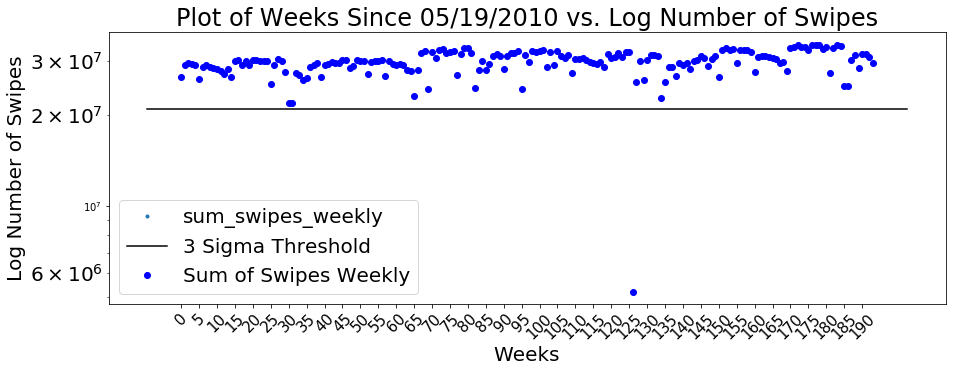

In [141]:
# this was adapted from dr. bianco's FDNYdeaths notebook
ax = mta_sum_by_wk['sum_swipes_weekly'].plot(logy=True, figsize=(15,5), style=".")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k', label = '3 Sigma Threshold')
pl.plot(mta_sum_by_wk['sum_swipes_weekly'], 'bo', label = 'Sum of Swipes Weekly')
pl.xticks(np.arange(0, 195, step=5), rotation=45, fontsize=15)
pl.yticks(fontsize=10)
pl.ylabel("Log Number of Swipes", fontsize=20)
pl.xlabel("Weeks", fontsize=20)
pl.title("Plot of Weeks Since 05/19/2010 vs. Log Number of Swipes")
pl.legend(loc = 3)

### Figure 4: Looking at the plot above it looks like that around week 125, there is an event which is > 3 sigmas from the whole time series. Finding that value in the array, it is at around week 127 with 5215466 swipes total that week.

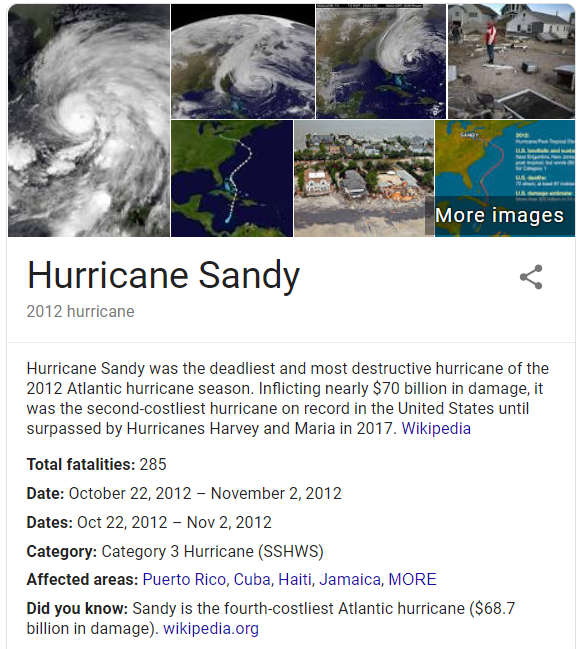

In [142]:
Image(filename = "Sandy.PNG")

# Task 2: Finding Trends

## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [143]:
## flatten the dataframe to take the mean over the swipes per station per weeks
mta_mean_by_card_types = np.nanmean(mta, axis = 0)
shape(mta_mean_by_card_types)

(23, 194)

In [144]:
mta_mean_by_card_types_df = pd.DataFrame(mta_mean_by_card_types,
                                         index = ridetype).T # transpose the matrix

In [145]:
mta_mean_by_card_types_df.head(5) # just to see if the df looks right

10t         14d         1d          2t         30d           7d  \
0  19157.461667  883.976667  79.438333  310.688333   77.783333  6162.175000   
1  20877.866667  972.323333  85.578333  331.816667  107.023333  6636.115000   
2  21277.483333  976.761667  85.831667  332.551667   94.761667  6721.488333   
3  21089.230000  937.441667  86.543333  327.086667   62.153333  6721.026667   
4  21349.263333  914.536667  85.028333  324.578333   58.456667  6542.183333   

            ada       afas         exp           ez  ...        month  \
0  14252.998333  16.541667  555.098333   853.156667  ...   204.993333   
1  15810.425000  19.513333  471.026667   963.140000  ...   253.015000   
2  15794.001667  20.233333  503.151667  1025.666667  ...   252.335000   
3  15749.906667  18.473333  508.960000  1010.221667  ...   244.928333   
4  15489.776667  17.298333  559.406667   938.850000  ...   229.586667   

           rfm          rr        sen      spec        tcmc          t  \
0  1316.620000   99.451667  46.805000 -0.230000  207.591667  34.870000   
1  1513.215000  115.116667  53.656667 -0.231667  202.623333  35.885000   
2  1523.311667  115.728333  54.135000 -0.228333  203.406667  35.493333   
3  1504.020000  113.270000  53.778333 -0.228333  203.190000  35.821667   
4  1425.728333  110.401667  52.995000  0.066667  199.400000  33.601667   

       umlim      xbus  stud  
0   9.983333  0.366667  -1.0  
1   9.968333  0.558333  -1.0  
2  10.588333  0.546667  -1.0  
3  10.755000  0.578333  -1.0  
4  10.295000  0.526667  -1.0  

[5 rows x 23 columns]

In [146]:
mta_mean_by_card_types_df.describe()

10t          14d          1d          2t         30d  \
count    194.000000   194.000000  194.000000  194.000000  194.000000   
mean   22070.390584  1046.286856   93.621091  311.779983   80.698600   
std     2026.077147   151.441907   12.700442   29.395951   21.111733   
min     3885.976667   176.598333   16.771667   57.933333    1.880000   
25%    21108.278750   964.359583   85.125833  300.909583   66.857917   
50%    22444.884167  1043.571667   95.264167  318.635833   84.365000   
75%    23225.690000  1140.231667  103.779583  329.686667   98.191667   
max    25513.598333  1340.536667  114.018333  344.535000  114.033333   

                 7d           ada        afas         exp           ez  \
count    194.000000    194.000000  194.000000  194.000000   194.000000   
mean    7990.859708  14930.571246    2.912552   80.950533   165.448419   
std     1275.040088   1760.292817    6.789240  185.269564   369.796708   
min     1687.903333   2603.810000   -0.270000   -0.270000    -0.270000   
25%     7080.735000  14137.473750   -0.228333   -0.226667    -0.228333   
50%     7912.727500  15391.055000   -0.226667   -0.223333    -0.225000   
75%     8754.674583  16103.334583   -0.223333   -0.218750    -0.221667   
max    10769.331667  16909.146667   21.098333  607.043333  1282.683333   

          ...            month          rfm          rr         sen  \
count     ...       194.000000   194.000000  194.000000  194.000000   
mean      ...       179.598995   870.664888  203.213582  108.527105   
std       ...        39.674391   286.202880   63.847896   34.616250   
min       ...         4.773333   103.086667   30.183333   19.658333   
25%       ...       158.014583   686.352083  154.700000   84.317500   
50%       ...       175.488333   741.320000  207.215000  112.381667   
75%       ...       205.549167   950.630000  254.860000  135.537917   
max       ...       253.015000  1571.903333  334.500000  176.111667   

             spec        tcmc           t       umlim        xbus         stud  
count  194.000000  194.000000  194.000000  194.000000  194.000000   194.000000  
mean    45.713308  253.635808   35.726460   10.390799    1.099356   849.578986  
std     20.173107   58.294213    4.891283    1.701547    0.505026  1115.785862  
min     -0.231667   66.695000    8.348333    2.775000   -0.230000    -1.000000  
25%     26.509167  212.809583   34.742500    9.574583    0.657083    -1.000000  
50%     52.983333  242.220833   36.768333   10.418333    1.186667    -0.230000  
75%     60.970833  285.041667   39.068750   11.399167    1.517917  2177.305833  
max     82.853333  402.733333   41.281667   13.711667    2.038333  2657.383333  

[8 rows x 23 columns]

Text(0.5, 1.0, 'All MTA Stations and Card Type For 194 Weeks from May 19th, 2010')

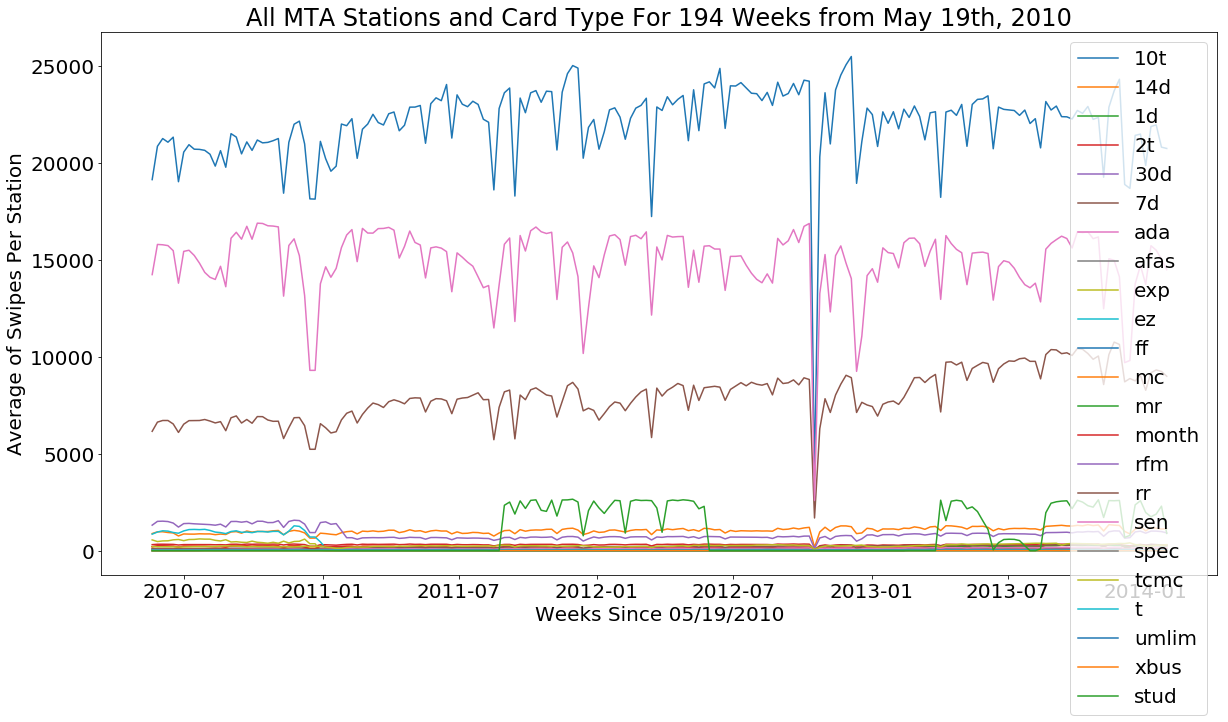

In [240]:
pl.figure(figsize(20,10))

for i in ridetype:
    pl.plot(dates_studied, mta_mean_by_card_types_df[i])
pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Average of Swipes Per Station')
pl.legend(loc = 0)
pl.title('All MTA Stations and Card Type For 194 Weeks from May 19th, 2010')

### Figure 5: Plot of the Weeks Since 05/19/2010 vs Average Swipes Per Station For each Card Type

In [148]:
mta_rolling_mean_by_card_types_df = mta_mean_by_card_types_df.rolling(20, min_periods=5).mean()

In [149]:
mta_rolling_mean_by_card_types_df.head()

10t      14d      1d          2t        30d           7d  \
0        NaN      NaN     NaN         NaN        NaN          NaN   
1        NaN      NaN     NaN         NaN        NaN          NaN   
2        NaN      NaN     NaN         NaN        NaN          NaN   
3        NaN      NaN     NaN         NaN        NaN          NaN   
4  20750.261  937.008  84.484  325.344333  80.035667  6556.597667   

            ada    afas         exp       ez  ...        month       rfm  \
0           NaN     NaN         NaN      NaN  ...          NaN       NaN   
1           NaN     NaN         NaN      NaN  ...          NaN       NaN   
2           NaN     NaN         NaN      NaN  ...          NaN       NaN   
3           NaN     NaN         NaN      NaN  ...          NaN       NaN   
4  15419.421667  18.412  519.528667  958.207  ...   236.971667  1456.579   

           rr     sen      spec        tcmc          t   umlim      xbus  stud  
0         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
1         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
2         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
3         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
4  110.793667  52.274 -0.170333  203.242333  35.134333  10.318  0.515333  -1.0  

[5 rows x 23 columns]

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


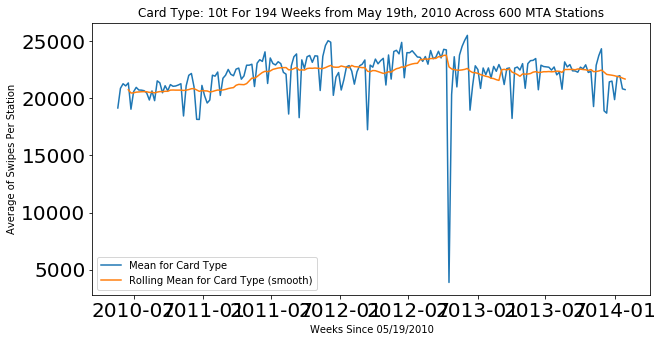

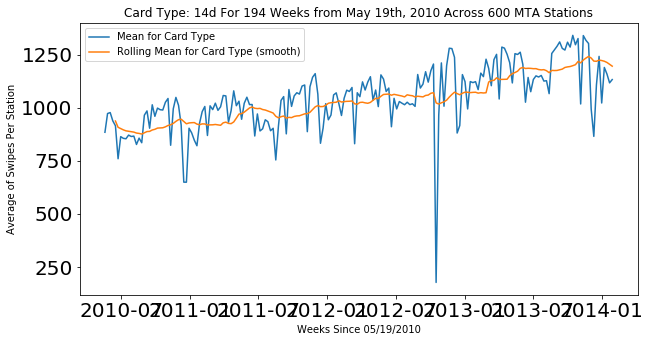

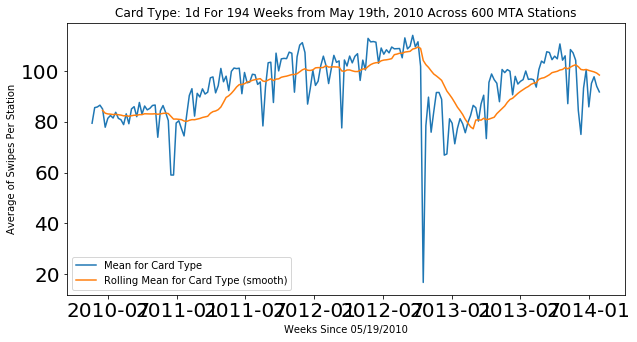

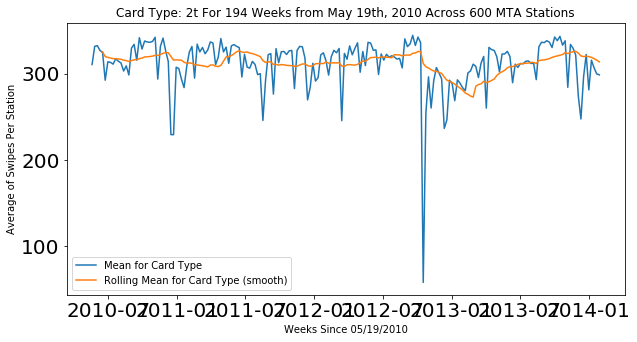

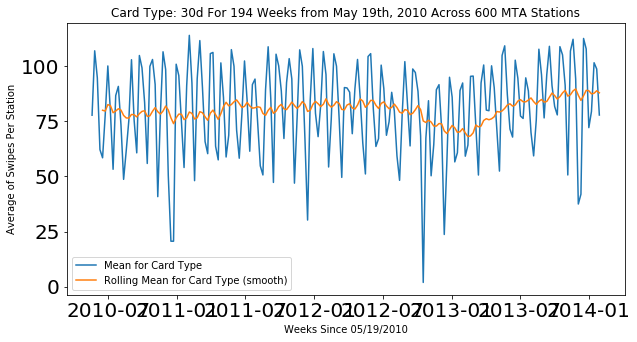

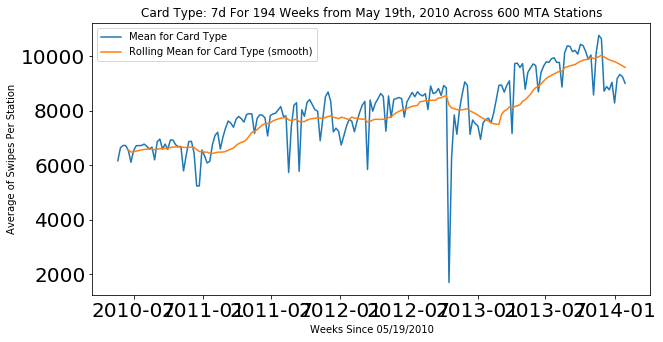

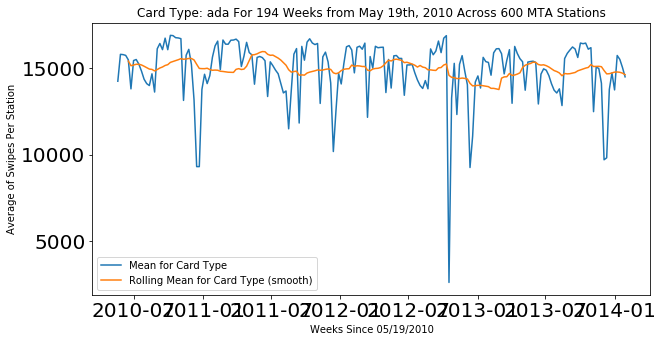

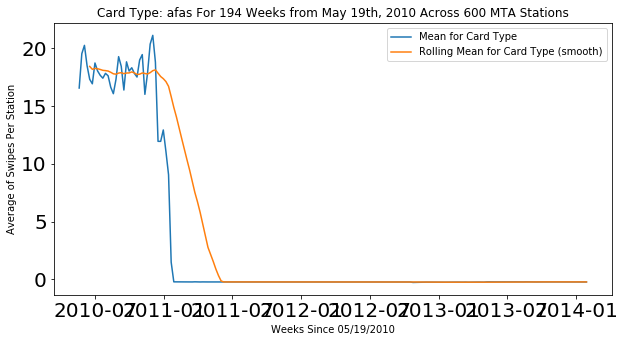

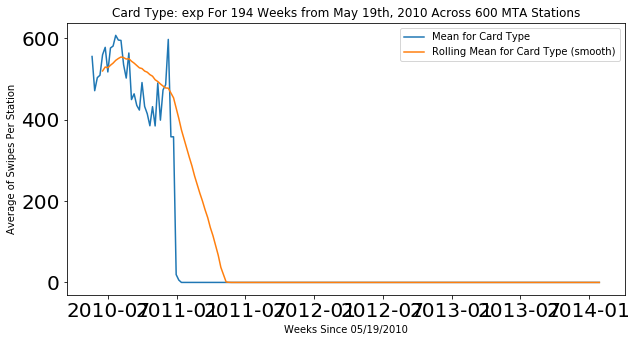

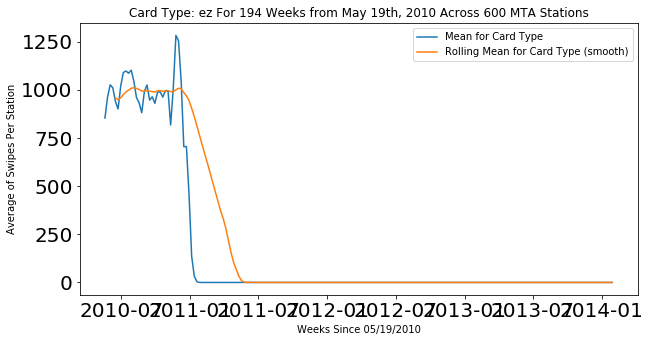

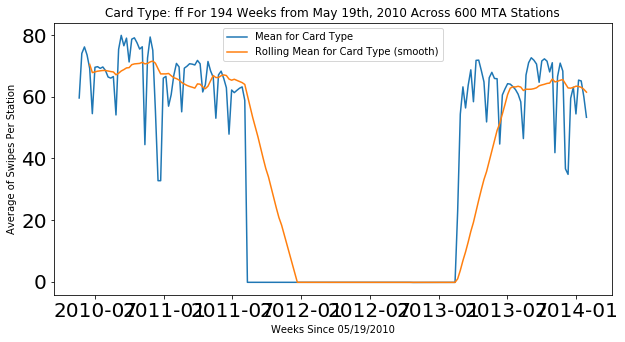

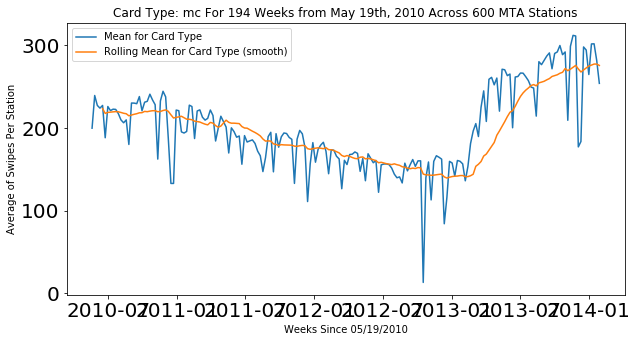

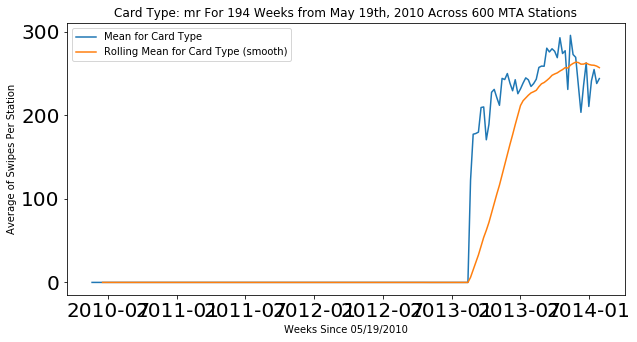

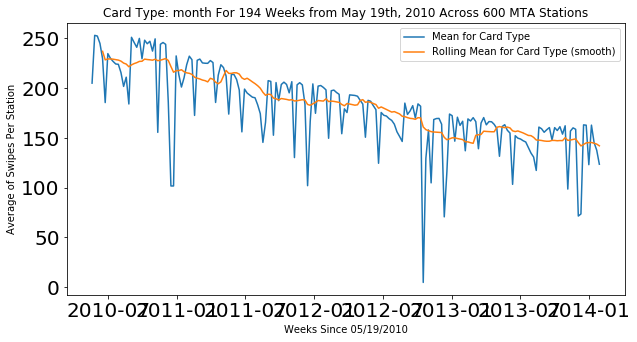

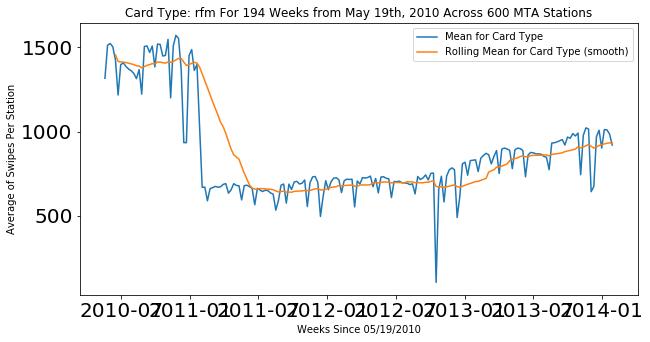

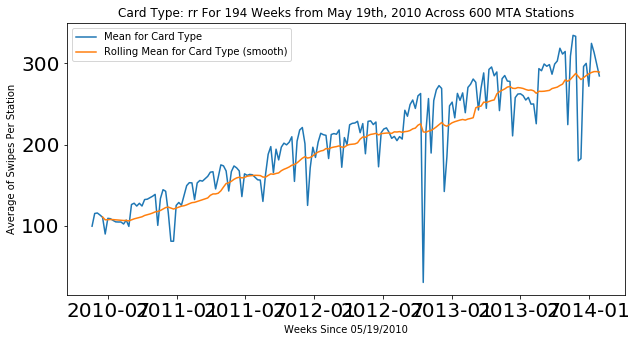

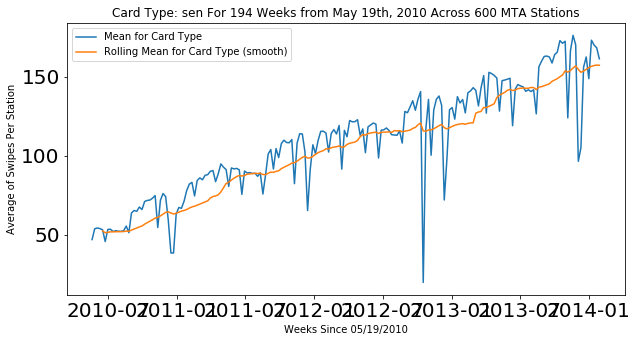

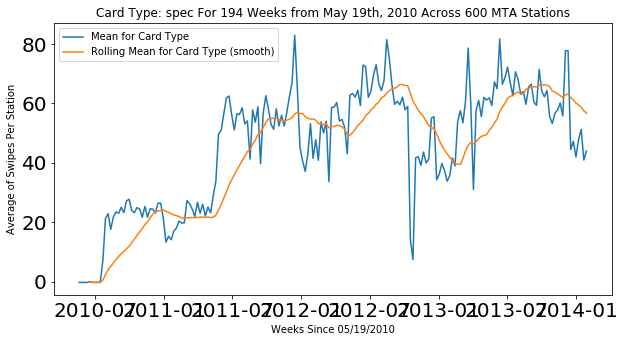

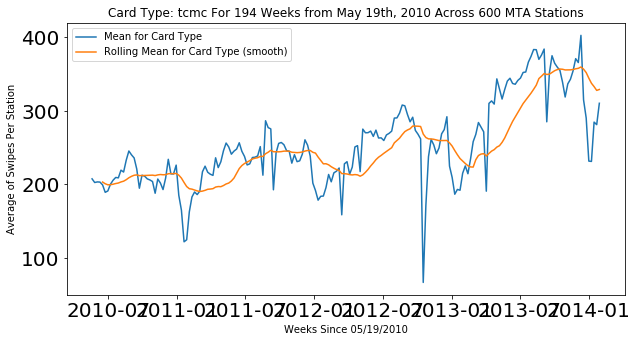

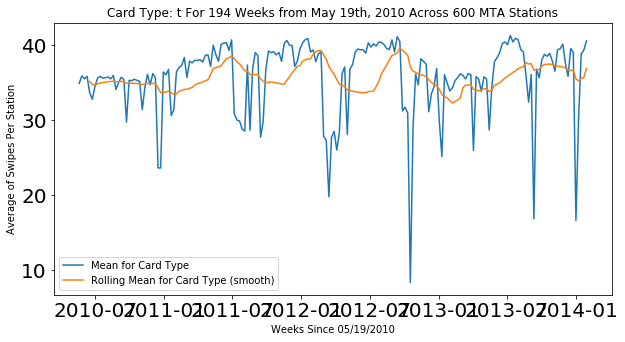

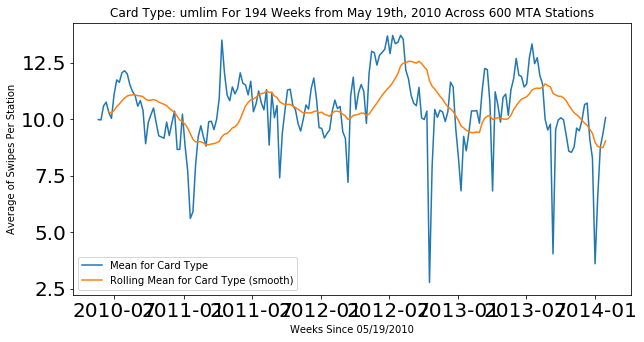

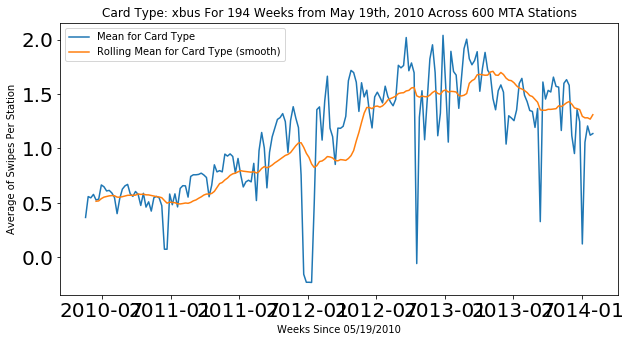

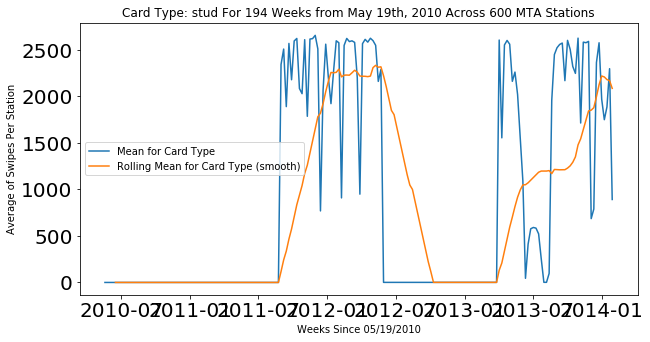

In [239]:
for i in ridetype:
    pl.figure(figsize(10,5))
    pl.plot(dates_studied, mta_mean_by_card_types_df[i], label = 'Mean for Card Type')
    pl.plot(dates_studied, mta_rolling_mean_by_card_types_df[i], label = 'Rolling Mean for Card Type (smooth)')
    pl.xlabel('Weeks Since 05/19/2010', fontsize = 10)
    pl.ylabel('Average of Swipes Per Station', fontsize = 10)
    pl.legend(loc = 0, fontsize = 10)
    pl.title('Card Type: '+ i + ' For 194 Weeks from May 19th, 2010 Across 600 MTA Stations', fontsize = 12)

### Figure 6: 23 Individual Plots for Each Card Type where both the means and the rolling means are graphed. The *blue* lines are showing the means and the *orange* lines are showing the rolling means. From the plots above it looks like there are some card types that have experienced increases and some that have experienced declines. 

* Increases:
    *14d (1)
    *7d (5)
    *mc (11)
    *mr (12)
    *rr (15)
    *sen (16)
    *spec (17)
    *tcmc (18)
    
* Declines:
    *afas (7)
    *exp (8)
    *ez (9)
    *month (13)
    *rfm (14)

In [151]:
first_ten = mta_mean_by_card_types_df.iloc[0:10,:].sum()

In [152]:
last_ten = mta_mean_by_card_types_df.iloc[184:194, :].sum()

In [153]:
card_stdev = np.std(mta_mean_by_card_types_df)

In [154]:
diff_first_last = last_ten - first_ten

In [155]:
ratio_change = (diff_first_last/ first_ten)

In [156]:
res_ratio = pd.concat([first_ten, last_ten,card_stdev, diff_first_last, ratio_change], 
                      axis=1, 
                      sort=False)

res_ratio.columns = ['first_ten', 'last_ten', 'card_stdev','diff_first_last', 'ratio_change']

In [157]:
res_ratio.sort_values('ratio_change')

first_ten       last_ten   card_stdev  diff_first_last  \
stud      -10.000000   17806.696667  1112.906410     17816.696667   
mr         -2.190000    2393.580000   105.237447      2395.770000   
afas      180.735000      -2.258333     6.771719      -182.993333   
exp      5456.041667      -2.238333   184.791448     -5458.280000   
ez       9984.691667      -2.281667   368.842392     -9986.973333   
month    2285.986667    1321.978333    39.572005      -964.008333   
rfm     14064.851667    9135.835000   285.464290     -4929.016667   
umlim     108.151667      87.055000     1.697156       -21.096667   
ff        685.295000     560.696667    32.719728      -124.598333   
ada    151957.233333  136737.161667  1755.750118    -15220.071667   
2t       3174.838333    2964.513333    29.320090      -210.325000   
t         349.898333     357.491667     4.878660         7.593333   
10t    205786.481667  210272.240000  2020.848552      4485.758333   
30d       796.983333     823.978333    21.057251        26.995000   
1d        829.361667     921.951667    12.667666        92.590000   
mc       2195.875000    2665.261667    49.430261       469.386667   
14d      8887.316667   11128.065000   151.051089      2240.748333   
7d      65569.440000   91125.853333  1271.749657     25556.413333   
tcmc     2012.056667    3084.223333    58.143776      1072.166667   
xbus        5.650000      10.896667     0.503722         5.246667   
rr       1072.980000    2785.826667    63.683127      1712.846667   
sen       517.856667    1511.006667    34.526918       993.150000   
spec        5.280000     528.750000    20.121047       523.470000   

       ratio_change  
stud   -1781.669667  
mr     -1093.958904  
afas      -1.012495  
exp       -1.000410  
ez        -1.000229  
month     -0.421703  
rfm       -0.350449  
umlim     -0.195066  
ff        -0.181817  
ada       -0.100160  
2t        -0.066247  
t          0.021702  
10t        0.021798  
30d        0.033871  
1d         0.111640  
mc         0.213758  
14d        0.252129  
7d         0.389761  
tcmc       0.532871  
xbus       0.928614  
rr         1.596345  
sen        1.917809  
spec      99.142045

### The table above shows the change ratios sorted from steepest decline to steepest increase.

# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features - models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 

## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [158]:
# reading more about how to handle nans in pythonic way
# https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html
# https://www.python-course.eu/numpy_masking.php
shape(mta)

(600, 23, 194)

In [159]:
mta[mta == -1] = np.nan

In [160]:
mta_2d_w = mta.reshape(600*23, 194)
shape(mta_2d_w)

(13800, 194)

In [161]:
# find the location for nans in the time series
find_nans = np.any(np.isnan(mta_2d_w), axis = 1)
shape(find_nans)

(13800,)

In [162]:
shape(mta_2d_w[~find_nans]) # this one doesn't filter out the zeros

(9174, 194)

In [163]:
# find the ind where nans and zeros are NOT present, 
# this the method providesd by Dr. Bianco
find_nans_zeros = mta.reshape(600*23, 194).std(1) > 0
shape(find_nans_zeros)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(13800,)

In [164]:
# create total time series excluding the nans and zeros
tots = mta_2d_w[find_nans_zeros]
shape(tots)

(7660, 194)

In [165]:
shape(mta_2d_w[~find_nans_zeros])

(6140, 194)

#### mg note: looks like we filter out 6140 ts

In [166]:
# find the mean per timeseries
ts_mean = np.nanmean(tots, axis = 1)

In [167]:
# find the standard deviation per timeseries
ts_std = np.nanstd(tots, axis = 1)

#### mg note
### feature: standardized number of rides per ts

In [168]:
# find the standardize number of rides per timeseries
# y = (x - mean) / standard_deviation
# from https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

standardized_ts = np.empty_like(tots)

for i in range(len(tots)):
    for j in range(len(tots[i])):
        standardized_ts[i][j] = ((tots[i][j] - ts_mean[i])/ts_std[i])

In [169]:
standardized_ts

array([[-0.65640584, -0.30638067,  0.20460498, ...,  0.50353158,
        -0.36514402, -0.84802546],
       [-0.79328051, -1.20611739, -0.97676357, ...,  1.54612853,
         1.47732238,  1.52319315],
       [-1.34422851, -1.46712217, -0.6068666 , ...,  0.99075089,
         0.25338898,  0.49917628],
       ...,
       [-0.07198158, -0.07198158, -0.07198158, ..., -0.07198158,
        -0.07198158, -0.07198158],
       [-2.21145941, -2.21145941, -2.21145941, ...,  0.53025565,
         0.26993968,  0.12158756],
       [ 0.16821441, -0.85404281, -1.14892471, ...,  0.38446113,
        -0.50018454,  0.40411993]])

In [170]:
shape(standardized_ts)

(7660, 194)

Text(0.5, 1.0, 'Week Number Since 05/09/2010')

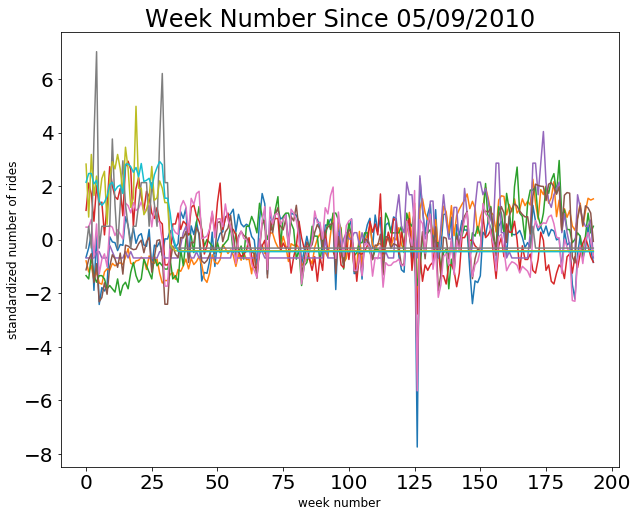

In [171]:
pl.figure(figsize(10,8))
for i in range(10):
    pl.plot(standardized_ts[i])
pl.xlabel("week number", fontsize = 12)
pl.ylabel("standardized number of rides", fontsize = 12)
pl.title("Week Number Since 05/09/2010")

### Figure 7: X axis shows the weeks since May 19th 2010 and the y axis shows the values for the standardized # of rides per time series. Only the 1st ten time series were plotted in the chart above. There are over 9000 time series in the data set. Lastly, the graph above also shows the drop/ event change around week 125 which is what was identified in task 2. 

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


### mg note: 
### features: slope and intercept

In [172]:
# followed the guide below for directions on how to fit a line to the data
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

allfits = []
wks = np.array(range(194)) # the x axis is weeeks
wks = sm.add_constant(wks) # add a constant, this will be the intercept

for i in range(len(standardized_ts)):
    model = sm.OLS(standardized_ts[i], wks)
    allfits.append(model.fit())
    

In [173]:
print(allfits[0].summary()) # to just see 1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.005734
Date:                Thu, 13 Dec 2018   Prob (F-statistic):              0.940
Time:                        20:16:02   Log-Likelihood:                -275.27
No. Observations:                 194   AIC:                             554.5
Df Residuals:                     192   BIC:                             561.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.144     -0.065      0.9

In [174]:
[a.params[0] for a in allfits[:10]] # to see the coef of the first 10, this is the slope of the line

[-0.009416561872008771,
 -1.454728940067163,
 -1.0690675778926169,
 1.0671791760745915,
 -1.0233822045957095,
 -0.8713689502519477,
 0.5719570453584066,
 0.7468965772692173,
 1.044647866741815,
 1.1035788353752414]

In [175]:
[a.params[1] for a in allfits[:10]] # to see the coef of the first 10, this is the contant added of the line

[9.758095204154222e-05,
 0.01507491129603278,
 0.011078420496296554,
 -0.011058851565539807,
 0.010604996938815645,
 0.00902973005442433,
 -0.005927016014076753,
 -0.007739860904344222,
 -0.01082536649473384,
 -0.011436050107515458]

### mg note: make features for 
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station


In [176]:
print('timeseries means: ',ts_mean, '\n timeseries mean shape: ' ,shape(ts_mean))
print('timeseries std: ',ts_std, '\n timeseries std shape: ',shape(ts_std))
# just to remind myself of what was the time series means and std

timeseries means:  [3.54891753e+03 1.44587629e+02 1.79381443e+01 ... 1.54639175e-02
 1.58012371e+03 1.93443299e+02] 
 timeseries mean shape:  (7660,)
timeseries std:  [3.91400424e+02 4.36007549e+01 8.13711673e+00 ... 2.14831608e-01
 7.14516263e+02 5.08678233e+01] 
 timeseries std shape:  (7660,)


In [177]:
# this is how Dr. Bianco got station ids
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid_no_nans = stationid[mta.reshape(600 * 23, 194).std(1) > 0]
shape(stationid_no_nans)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(7660,)

In [178]:
stationid_no_nans ### given cube nature the 1st indice should be repeated

array([  2,   2,   2, ..., 550, 550, 550])

In [179]:
# create an array that index / label the card types
ridetype_label = np.tile(np.array(range(23)),600)
label = ridetype_label[find_nans_zeros]
shape(label)

(7660,)

In [180]:
label[:50]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 18,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [181]:
# find means per station
stationsmeans = np.nanmean(mta.reshape(600, 23 * 194), axis=1)    
shape(stationsmeans)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(600,)

In [182]:
# find std per station
stationsstd = np.nanstd(mta.reshape(600, 23 * 194), axis = 1)  
shape(stationsstd)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(600,)

In [183]:
# 600 stations, find means per station
normedtsmean = np.ones(shape(stationid_no_nans)).astype(float)
normedtsstd = np.ones(shape(stationid_no_nans)).astype(float)

for i in range(600):
    ai = np.where(np.isin(stationid_no_nans, i)) 
    # creates an array of 1d with the indices of the array reflecting values from that specific subway station
    for j in ai[0]:
        normedtsmean[j] = tots[j].mean() / stationsmeans[i]
        normedtsstd[j] =  tots[j].std() / stationsstd[i]   

### MG's Note: Split the standardized data into training and testing data sets

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [184]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [185]:
# array of 4 features in order:
# slope of line, x- intercept, mean of ts/ normedtsmean, std of ts/ normedtsstd
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [186]:
np.mean(tots)


3650.981991736427

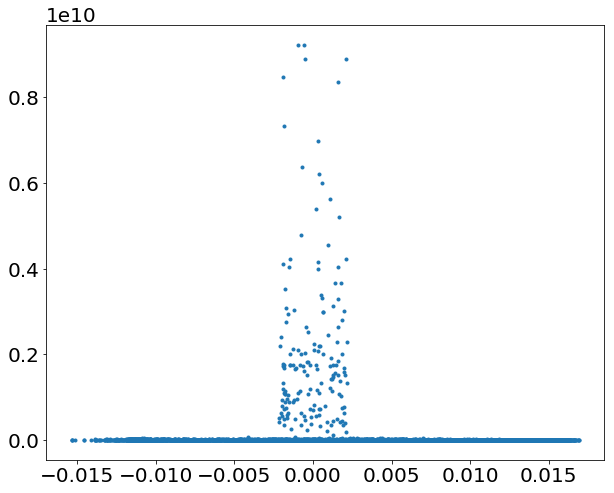

In [187]:
pl.plot(X_train[:,1], X_train[:,3], '.')

In [188]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [189]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

#### mg notes: random forest classifier
from https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
"Random Forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model."

In [190]:
clf = rfc(random_state = 10)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [191]:
clf.fit(X_train, y_train)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [192]:
clf.score(X_test,y_test)

0.7484177215189873

In [193]:
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

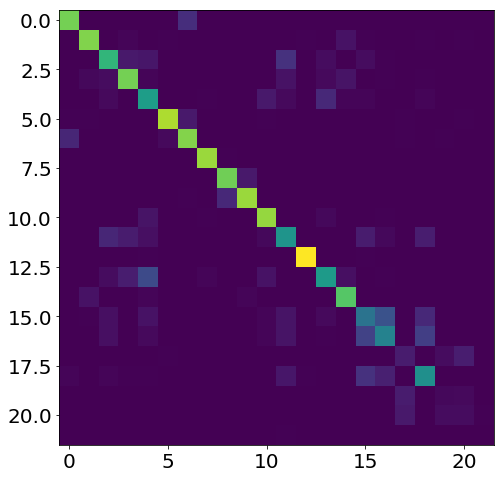

In [194]:
imshow(confusion_matrix(y_test, y_pred))

#### Figure 8: Confusion matrix on the performance of the classifier and the score was 0.74 for the testing dataset obtained using an out-of-bag estimate.

 #### use classification_report to assess the model and clf.feature_importances_ to find the important features

In [195]:
print(classification_report(y_test, y_pred, target_names=ridetype[:-1]))

              precision    recall  f1-score   support

         10t       0.86      0.86      0.86       135
         14d       0.91      0.89      0.90       133
          1d       0.69      0.66      0.67       148
          2t       0.76      0.79      0.78       147
         30d       0.53      0.66      0.59       124
          7d       0.96      0.90      0.92       144
         ada       0.80      0.85      0.82       142
        afas       0.97      0.99      0.98       126
         exp       0.86      0.92      0.89       125
          ez       0.91      0.87      0.89       143
          ff       0.83      0.91      0.87       137
          mc       0.57      0.55      0.56       138
          mr       0.99      0.99      0.99       149
       month       0.70      0.55      0.62       146
         rfm       0.82      0.91      0.86       119
          rr       0.44      0.41      0.42       138
         sen       0.53      0.46      0.49       142
        spec       0.32    

In [196]:
clf.feature_importances_

# slope of line, x- intercept, mean of ts/ normedtsmean, std of ts/ normedtsstd


array([0.17050266, 0.21157418, 0.35817332, 0.25974984])

In [197]:
shape(np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]))

(4, 7660)

#### mg note:
#### classification report: Precision score looks high on average at 0.75 with a range of 0 to 0.99. Some were very low because the number of ts after cleaning out the nans were much smaller. that makes sense
#### feature importance: looks like the most important feature is the mean of normedtsmean

## Build a model that uses as input features each time stamp (194 features) :


In [198]:
# use the same split ratio
# the tots array is already organized in the shape of (7660,194)
X_train2, X_test2, y_train2, y_test2 = train_test_split(tots, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [199]:
np.array(X_train2).shape, np.array(X_test2).shape, np.array(y_train2).shape, np.array(y_test2).shape

((5132, 194), (2528, 194), (5132,), (2528,))

In [200]:
(~np.isfinite(X_train2)).sum(),(~np.isfinite(X_test2)).sum(),(~np.isfinite(y_train2)).sum(),(~np.isfinite(y_test2)).sum()

(0, 0, 0, 0)

In [201]:
clf.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [202]:
clf.score(X_train2,y_train2)

0.990257209664848

In [203]:
y_pred2 = clf.predict(X_test2)

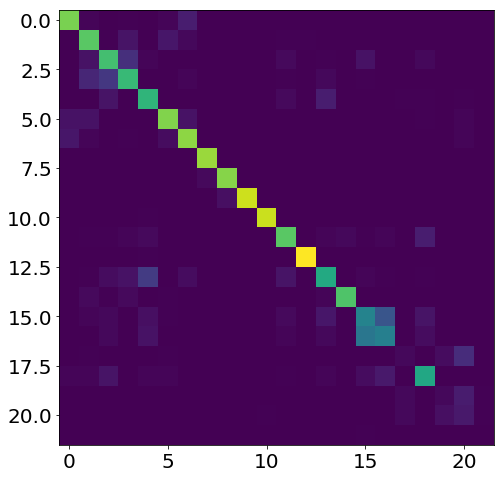

In [204]:
imshow(confusion_matrix(y_test2, y_pred2))

#### Figure 9: Confusion matrix on the performance of the classifier and the score was 0.99 for the training dataset obtained using an out-of-bag estimate.

In [205]:
print(classification_report(y_test2, y_pred2, target_names=ridetype[:-1]))

              precision    recall  f1-score   support

         10t       0.87      0.87      0.87       135
         14d       0.71      0.83      0.76       133
          1d       0.66      0.70      0.68       148
          2t       0.70      0.68      0.69       147
         30d       0.66      0.78      0.72       124
          7d       0.85      0.83      0.84       144
         ada       0.81      0.87      0.84       142
        afas       0.97      1.00      0.98       126
         exp       0.95      0.97      0.96       125
          ez       1.00      0.96      0.98       143
          ff       0.99      0.99      0.99       137
          mc       0.81      0.80      0.81       138
          mr       0.99      0.99      0.99       149
       month       0.73      0.62      0.67       146
         rfm       0.97      0.90      0.93       119
          rr       0.47      0.48      0.47       138
         sen       0.55      0.45      0.50       142
        spec       0.30    

In [206]:
print(clf.feature_importances_) # importance of the features, each of the 194 weeks

[0.01316149 0.01207258 0.00432296 0.00947587 0.00717421 0.00590219
 0.00521223 0.00780517 0.00825963 0.00409523 0.01233409 0.01164793
 0.01173599 0.00772454 0.00887955 0.0034309  0.00791958 0.01096235
 0.00450743 0.00381885 0.00721702 0.00686893 0.00996636 0.00270286
 0.00615672 0.01020128 0.00708982 0.00694941 0.00450181 0.01899547
 0.01461877 0.01142736 0.01108583 0.00836634 0.01879901 0.01915262
 0.0049154  0.00322304 0.00811767 0.00330112 0.01101445 0.00398605
 0.02232927 0.00223181 0.00395187 0.0070436  0.00367867 0.01158796
 0.00328304 0.00190142 0.00508482 0.00212997 0.0027308  0.0018351
 0.00254141 0.00092609 0.00760919 0.00818215 0.00171017 0.00157176
 0.00209236 0.00686052 0.006639   0.00226516 0.0013743  0.00285594
 0.00258647 0.00483757 0.0018703  0.00695271 0.00635467 0.00167286
 0.01108784 0.00159506 0.00098082 0.00243111 0.00133511 0.00304824
 0.00186925 0.00255851 0.0018132  0.00258797 0.00667081 0.00224397
 0.0021761  0.00165423 0.00179598 0.00674575 0.00233447 0.00234

In [207]:
feature_imp2 = clf.feature_importances_

Text(0.5, 1.0, 'Week Number Since 05/09/2010')

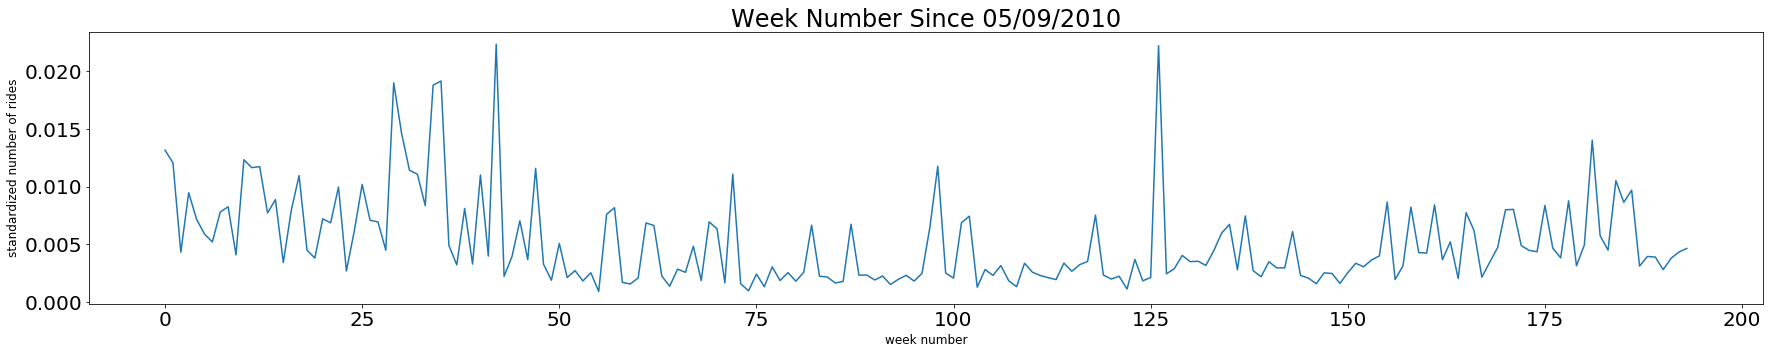

In [208]:
pl.figure(figsize(30,5))
pl.plot(feature_imp2)
pl.xlabel("week number", fontsize = 12)
pl.ylabel("standardized number of rides", fontsize = 12)
pl.title("Week Number Since 05/09/2010")

### Figure 10: Plot of feature importance with each week as a feature

#### mg note:
#### classification report: Precision score looks high on average at 0.78 with a range of 0 to 1.00. Some were very low because the number of ts after cleaning out the nans were much smaller. that makes sense
#### feature importance: From the features it looks like about week 30, 40, and 125 were of high importance

# Assignment 1 MTA Cardtype Timeseries Analysis Part II
yg833

This assignment is a continuation from the week prior.For this week, I worked with QY(qg412)


# Task 4: Fourier transform
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**

from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [209]:
station_sums = np.nansum(mta, axis=1) # sum per station across 194 weeks
print(shape(station_sums), '\n', station_sums)

(600, 194) 
 [[126878. 149477. 152383. ...  78901.  74591.  76833.]
 [ 37306.  46464.  49359. ...      0.      0.      0.]
 [  6606.   6881.   7229. ...   8171.   7907.   6790.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]


In [210]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT) 
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).
# 600 stations, find rfft per station
station_dft = (np.abs(np.fft.rfft(station_sums, axis = 1))**2) # power spectrum, square for absolute value

# https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb
print(shape(station_dft), '\n', station_dft)

(600, 98) 
 [[5.36381339e+14 7.20272646e+12 1.85938937e+12 ... 3.21601762e+10
  4.49887441e+09 3.41207395e+10]
 [1.60682967e+13 5.17107026e+12 9.11181544e+10 ... 3.04754758e+08
  2.62383960e+09 3.05786880e+09]
 [1.97504516e+12 1.37886011e+06 3.89486562e+09 ... 1.74185456e+08
  2.08109487e+08 8.20822500e+06]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [211]:
N = len(mta[0][0])
N
# since we are measuring in weeks, the smallest unit would be 2 weeks

194

There are n=194 datapoints in the series


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

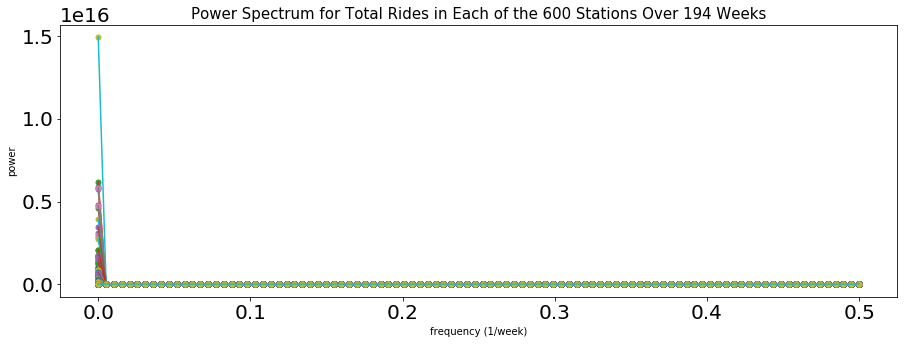

In [212]:
# plot all 600 stations from the series named station_dft (discreet fourier transformations)

print ("There are n=%d datapoints in the series"%N)

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], '-')

pl.xlabel('frequency (1/week)', fontsize=10)
pl.ylabel('power', fontsize=10)
pl.title('Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks', fontsize=15)

### Figure 11: In the power spectrum above of total rides for each of the 600 stations over 194 week, we see on the x-axis is in units of inverse frequencies. Therefore further from the 0,0 point, its 2 weeks (the smallest unit).

In [213]:
print (" The first two frequency (slowest) calculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate id every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

 The first two frequency (slowest) calculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.005154639175257732 = period: every 194.0 weeks


The fastest frequency you can calculate id every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


#### mg note: seeing the above for slowest, it makes sense to drop the first index value which is inf

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

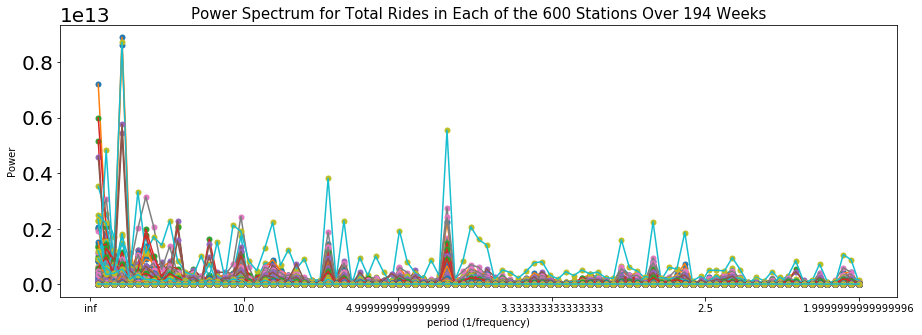

In [214]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

# pl.xlim(0,0.05)
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (1/frequency)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 12: From the above chart, it seems like the high periodicity between 3.3333 and 4.999 period after dropping the first FFT value.

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

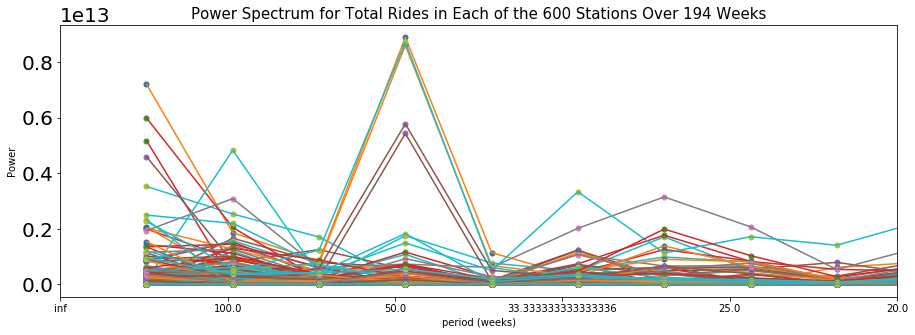

In [215]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (weeks)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

### Figure 13: In the above plot the first value of the FFT is dropped, and zoomed into the weeks. Showing that at around 33 weeks, there is high periodicity

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

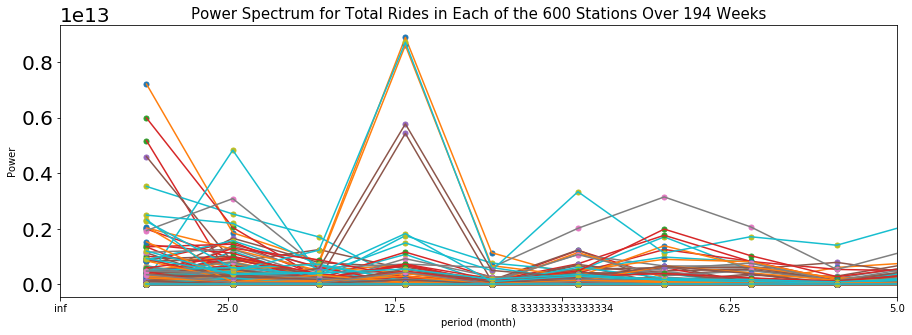

In [216]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/4/f) for f in ax.get_xticks()], fontsize=10)  # divide by 4 because to get the months from 33 weeks
pl.xlabel("period (month)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 14: Adjusting the x-scale from plot 4 to read months. So its just about 8 months where we see high periodicity

### Identify Stations

From the charts above, we see that there is high periodicity at about 52 weeks. We want to find where the top 4 stations demonstrating the highest periodicity at each 52 weeks. 

In [217]:
freq = np.fft.rfftfreq(N, 1.0)
shape(freq)

(98,)

In [218]:
1/freq[4]

48.5

In [219]:
expected_freq = 1/52
expected_freq # because on annual period so freq is 1/52

0.019230769230769232

The freq and the expected freq is similar

In [220]:
number_times_repeated = np.where(np.abs(freq - 1.0/52) == min(np.abs(freq - 1.0/52)))[0]
number_times_repeated

array([4])

In [221]:
(N/number_times_repeated)[0]

48.5

In [222]:
194/4

48.5

In [223]:
# each period is 48.5 weeks

In [224]:
find_4th = np.empty([600])
for i in range(len(station_dft)):
    find_4th[i] = station_dft[i][4]

In [225]:
find_4th.argsort()[-4:][::-1] # the index of the stations

array([  0, 194, 150, 327])

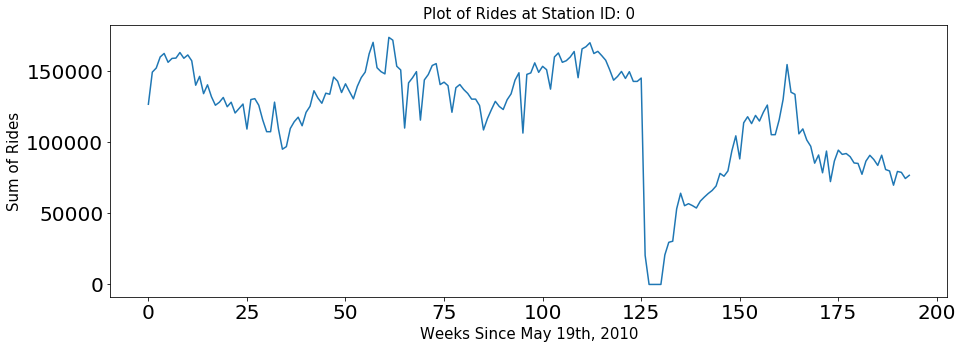

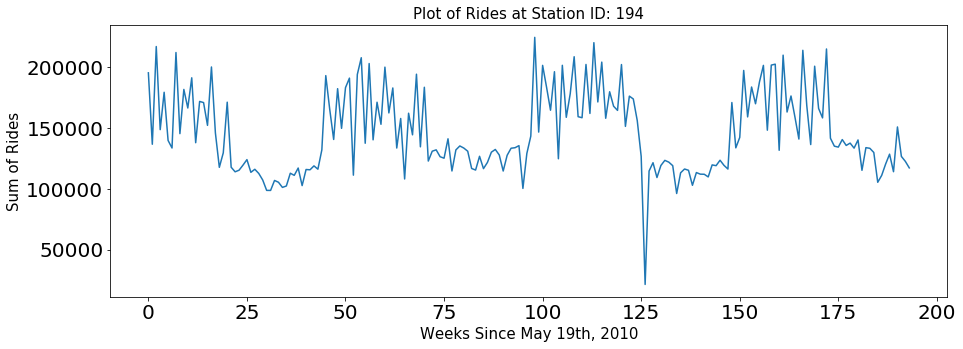

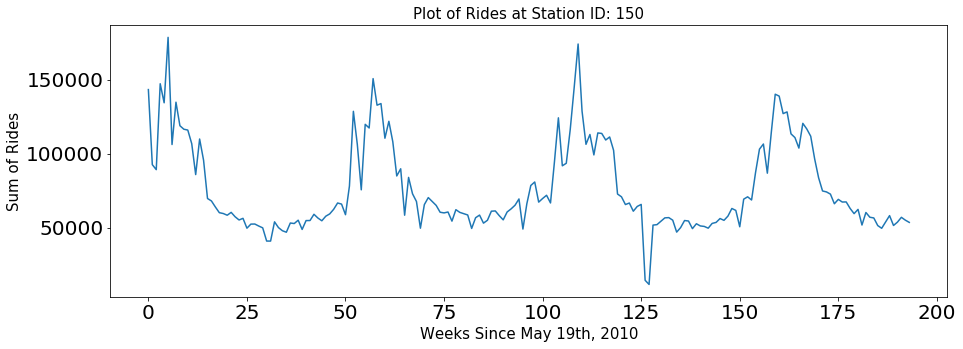

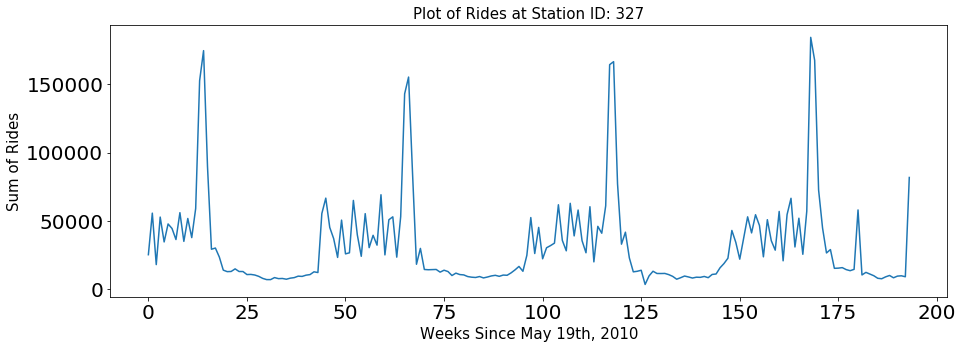

In [226]:
ided_stations = [0, 194, 150, 327]
len(ided_stations)
ided_stations[3]
for i in range(0, 4):
    fig=pl.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    ax.plot(station_sums[ided_stations[i]])
    pl.xlabel("Weeks Since May 19th, 2010", fontsize=15)
    pl.ylabel("Sum of Rides", fontsize=15)
    pl.title("Plot of Rides at Station ID: " + str(ided_stations[i]) , fontsize=15)

### Figure 15: Plot of each of the identified stations to further inspect for periodicity for the duration of sum rides from May 19, 2010

# Task 5: Extra Credit
**Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:**
- are there distinct clusters?
- do they reflect the card type or station? 

To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: 
subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead: 

observation = (observation -observation.mean()) / observation.std()
each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

see this regarding whitening: https://github.com/fedhere/UInotebooks/blob/master/cluster/whitening.md

In [227]:
ts_w_4_feats = np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]).T

In [228]:
shape(ts_w_4_feats)

(7660, 4)

In [229]:
# find the mean per feature
ft_mean = np.nanmean(ts_w_4_feats, axis = 1)

In [230]:
# find the std per feature
ft_std = np.nanstd(ts_w_4_feats, axis = 1)

In [231]:
# find the standardize number of rides per timeseries
# y = (x - mean) / standard_deviation
# from https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

standardized_ft = np.empty_like(ts_w_4_feats)

for i in range(len(ts_w_4_feats)):
    for j in range(len(ts_w_4_feats[i])):
        standardized_ft[i][j] = ((ts_w_4_feats[i][j] - ft_mean[i])/ft_std[i])

Text(0.5, 1.0, 'Elbow curve')

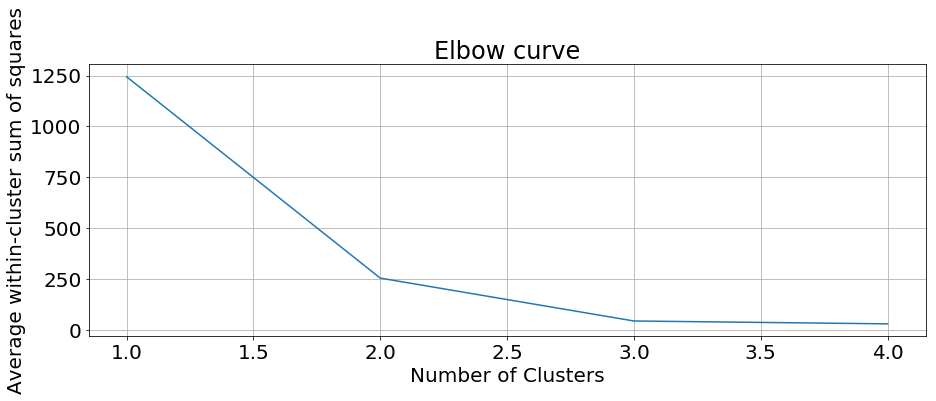

In [232]:
### adapted from https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method
distorsions = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(standardized_ft)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
pl.plot(range(1, 5), distorsions)
pl.grid(True)
pl.xlabel('Number of Clusters')
pl.ylabel('Average within-cluster sum of squares')
pl.title('Elbow curve')

### Figure 16: Elbow Curve of K Clusters and determine the optimal number of clusters as discussed in class. Looks to at 3

In [233]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
shape(standardized_ft)

(7660, 4)

In [234]:
#cluster with kmeans
nc = 3 # setting the number of clusters
km = KMeans(n_clusters=nc, random_state=444).fit(standardized_ft)
y_km = kmeans.predict(standardized_ft)

In [235]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
print(km.labels_.shape, km.labels_)

(7660,) [0 0 0 ... 1 0 0]


In [236]:
km.cluster_centers_ # this gives you the cluster centers

array([[-0.60751187, -0.60750622, -0.5151395 ,  1.73015759],
       [-0.96664961, -0.96664961,  1.28683165,  0.64646757],
       [-0.750734  , -0.75073753, -0.18140903,  1.68288056]])

In [237]:
cluster_labels = km.labels_

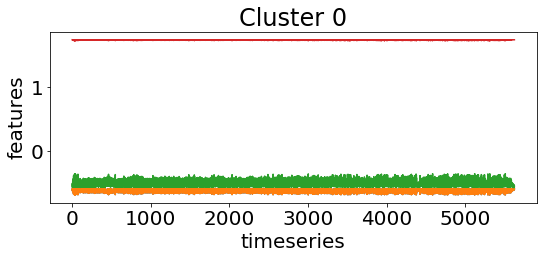

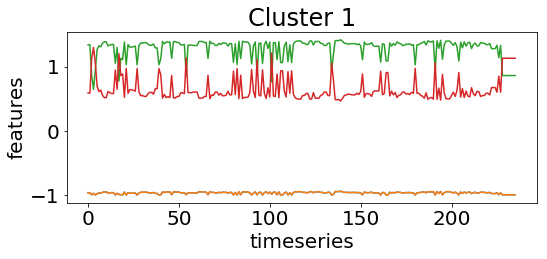

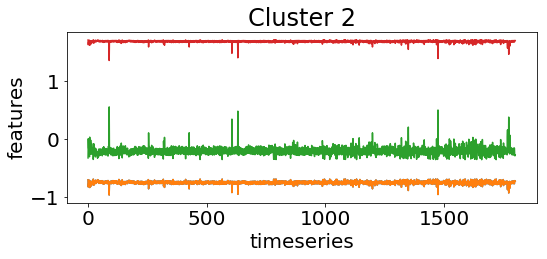

In [244]:
for i in range(nc):
    fig=pl.figure(figsize=(8,4))
    ax=fig.add_subplot(111)
    ax.plot(standardized_ft[cluster_labels == i])    
    ax.set_title('Cluster ' + str(i))
    ax.set_xlabel('timeseries')
    ax.set_ylabel('features')
    plt.tight_layout()

#### Figure 17: This is not really informative with the application of kMeans here. Seems like Cluster 0 and Cluster 2 plot is kind of similiar but really am not sure what it is telling me about the similiarities of the timeseries based on the 4 engineered features. 